In [4]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install grad-cam==1.3.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.0 MB/s eta 0:00:003.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.6-py3-none-any.whl size=20181 sha256=1295a045dc09205e0ae755d28840523e6d5886c41c5ba7b468977af3e634cb69
  Stored in directory: /home/fast/.cache/pip/wheels/a3/b7/1b/35e4477b6259e8ca7720fbb10d31d3fc8190a9c41f6e3b4340
Successfully built grad-cam
  Attempting uninstall: grad-cam
    Found existing installation: grad-cam 1.5.5
    Uninstalling grad-cam-1.5.5:
      Successfully uninstalled grad-cam-1.5.5
Note: you may need to restart the kernel to use updated packages.


In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Optional: install pytorch-grad-cam
# pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [22]:
train_dir = "/home/fast/Downloads/binary_dataset/Training"
val_dir = "/home/fast/Downloads/binary_dataset/Testing"
batch_size = 32
num_epochs = 20
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val'])
}

dataloaders = {
    phase: DataLoader(image_datasets[phase], batch_size=batch_size,
                      shuffle=(phase == 'train'), num_workers=4)
    for phase in ['train', 'val']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [13]:
model = models.efficientnet_b3(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4, inplace=True),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(num_epochs):
    print('-' * 30)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects / len(image_datasets[phase])

        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_efficientnetb3.pth')

print(f"Training complete. Best val Acc: {best_acc:.4f}")

------------------------------
Epoch 1/20
train Loss: 0.4487 Acc: 0.8561
val Loss: 0.4647 Acc: 0.9512
------------------------------
Epoch 2/20
train Loss: 0.1119 Acc: 0.9617
val Loss: 0.1329 Acc: 0.9687
------------------------------
Epoch 3/20
train Loss: 0.0649 Acc: 0.9779
val Loss: 0.0364 Acc: 0.9886
------------------------------
Epoch 4/20
train Loss: 0.0385 Acc: 0.9874
val Loss: 0.0158 Acc: 0.9954
------------------------------
Epoch 5/20
train Loss: 0.0262 Acc: 0.9921
val Loss: 0.1819 Acc: 0.9962
------------------------------
Epoch 6/20
train Loss: 0.0250 Acc: 0.9928
val Loss: 0.0188 Acc: 0.9954
------------------------------
Epoch 7/20
train Loss: 0.0203 Acc: 0.9935
val Loss: 0.0179 Acc: 0.9924
------------------------------
Epoch 8/20
train Loss: 0.0123 Acc: 0.9975
val Loss: 0.3587 Acc: 0.9962
------------------------------
Epoch 9/20
train Loss: 0.0145 Acc: 0.9954
val Loss: 0.0181 Acc: 0.9947
------------------------------
Epoch 10/20
train Loss: 0.0129 Acc: 0.9958
val Loss

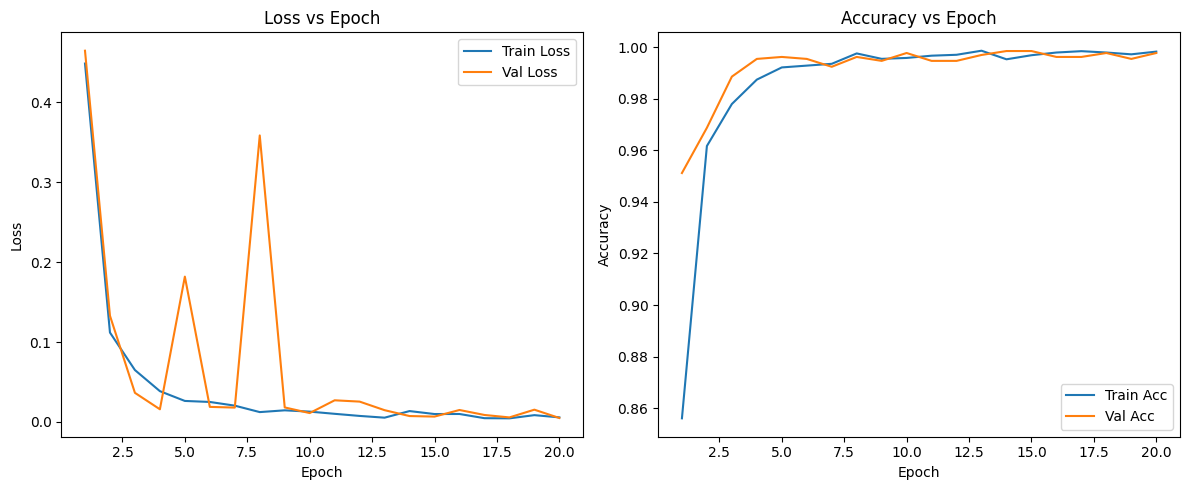

In [15]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

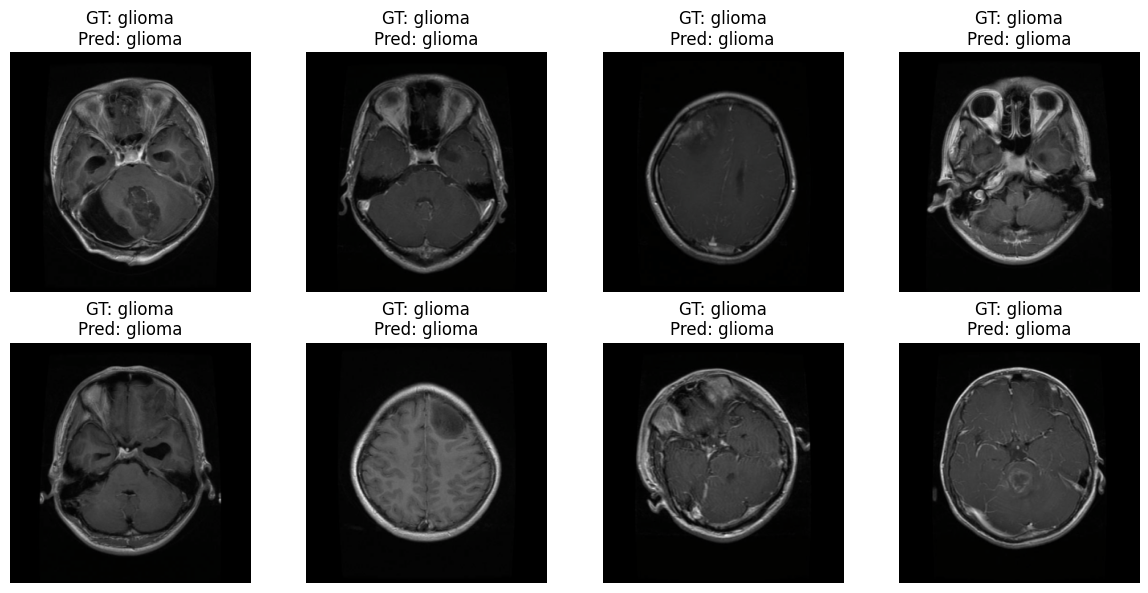

In [16]:
# Un-normalization helper
inv_norm = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def imshow(img, title=None):
    img = inv_norm(img).permute(1, 2, 0).clamp(0, 1).numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

model.eval()
imgs, labs = next(iter(dataloaders['val']))
imgs, labs = imgs.to(device), labs.to(device)
with torch.no_grad():
    outs = model(imgs)
    preds = outs.argmax(dim=1)

imgs, labs, preds = imgs.cpu(), labs.cpu(), preds.cpu()

plt.figure(figsize=(12, 6))
for i in range(min(8, imgs.size(0))):
    ax = plt.subplot(2, 4, i + 1)
    imshow(imgs[i], title=f"GT: {class_names[labs[i]]}\nPred: {class_names[preds[i]]}")
plt.tight_layout()
plt.show()

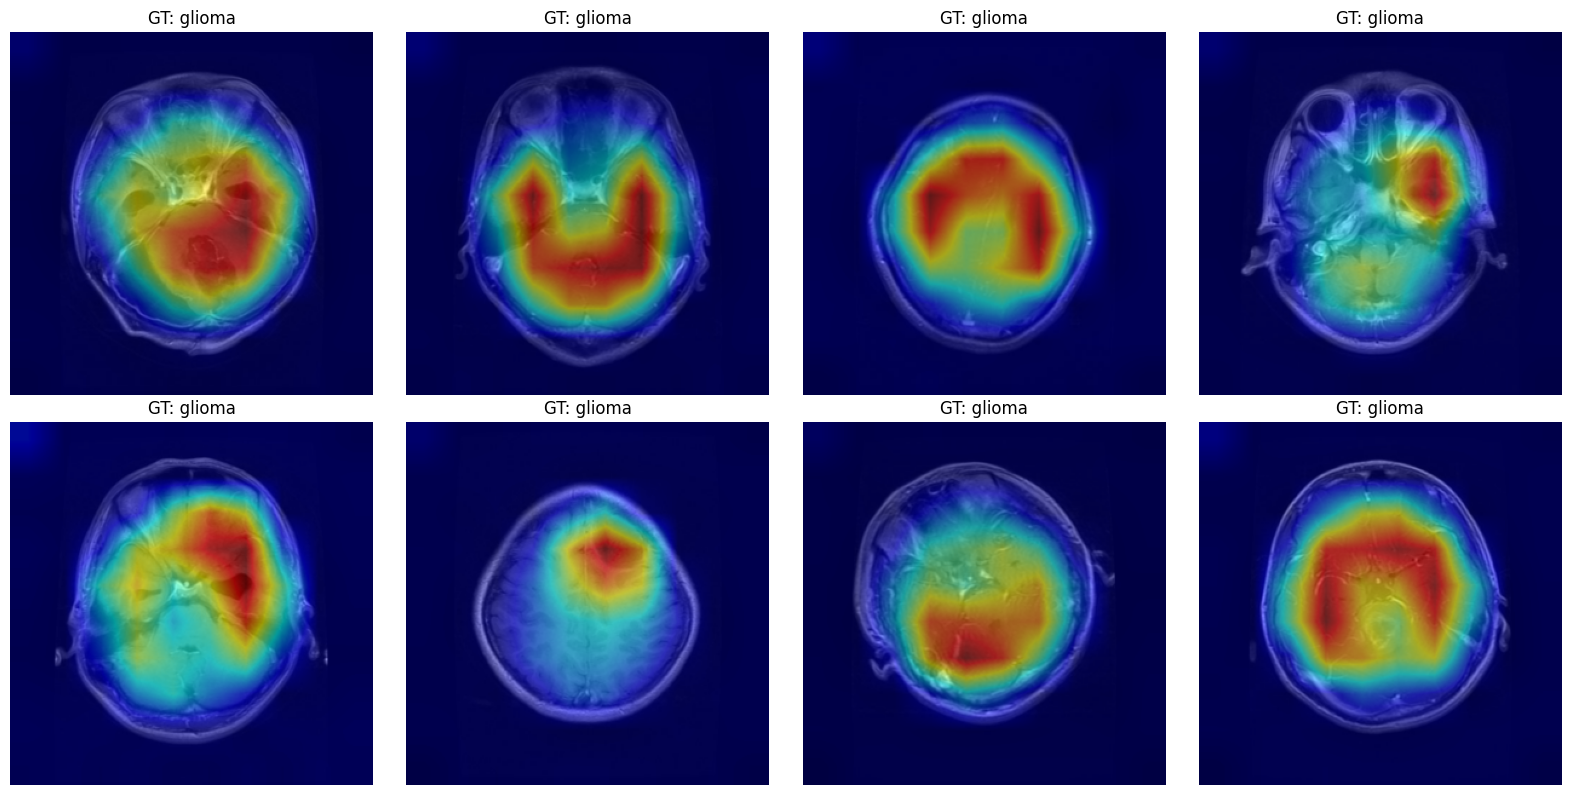

In [17]:
# Ensure the model is in evaluation mode
model.eval()

# Select the target layer for Grad-CAM
target_layer = model.features[-1]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)

# Generate Grad-CAM
grayscale_cams = cam(input_tensor=inputs)

# Visualize the Grad-CAM
plt.figure(figsize=(16, 8))
for i in range(min(inputs.size(0), 8)):
    img_np = inv_norm(inputs[i]).cpu().permute(1, 2, 0).clamp(0, 1).numpy()
    heatmap = grayscale_cams[i]
    cam_img = show_cam_on_image(img_np, heatmap, use_rgb=True)

    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(cam_img)
    plt.title(f"GT: {class_names[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [71]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 1. Instantiate the exact architecture used in training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate EfficientNet B3 (no pretrained weights by default)
model = models.efficientnet_b3(weights=None)  
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))
model.to(device)

# 2. Load weights with strict=False so mismatches don’t blow up
state = torch.load('best_efficientnetb3.pth', map_location=device)
model.load_state_dict(state, strict=False)
model.eval()

# 3. Prediction function
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.485, .456, .406],
                             std=[.229, .224, .225])
    ])
}

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    tensor = data_transforms['val'](img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
    return class_names[pred.item()], conf.item()

# Usage
img_path = "/home/fast/Downloads/Te-no_0010.jpg"
pred_class, confidence = predict_image(img_path)
print(f"Prediction: {pred_class} ({confidence*100:.2f}%)")

Prediction: notumor (100.00%)


In [18]:
# Load pretrained VGG16
model = models.vgg16(pretrained=True)
# Replace the classifier (fc) layers for our num_classes
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/fast/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/fast/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|████████████████████████████████████████| 528M/528M [00:16<00:00, 34.3MB/s]


In [20]:
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
best_acc = 0.0

for epoch in range(num_epochs):
    print('-'*30)
    print(f"Epoch {epoch+1}/{num_epochs}")
    for phase in ['train','val']:
        model.train() if phase=='train' else model.eval()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item()*inputs.size(0)
            running_corrects += (preds==labels).sum().item()

        epoch_loss = running_loss/len(image_datasets[phase])
        epoch_acc  = running_corrects/len(image_datasets[phase])
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc)
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase=='val' and epoch_acc>best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(),'best_vgg16.pth')

print(f"Training complete. Best val Acc: {best_acc:.4f}")

------------------------------
Epoch 1/20
train Loss: 0.3264 Acc: 0.8876
val Loss: 0.2340 Acc: 0.9191
------------------------------
Epoch 2/20
train Loss: 0.1408 Acc: 0.9522
val Loss: 0.1470 Acc: 0.9634
------------------------------
Epoch 3/20
train Loss: 0.1038 Acc: 0.9674
val Loss: 0.1348 Acc: 0.9596
------------------------------
Epoch 4/20
train Loss: 0.0827 Acc: 0.9720
val Loss: 0.0785 Acc: 0.9764
------------------------------
Epoch 5/20
train Loss: 0.0625 Acc: 0.9802
val Loss: 0.1424 Acc: 0.9619
------------------------------
Epoch 6/20
train Loss: 0.0604 Acc: 0.9807
val Loss: 0.0728 Acc: 0.9687
------------------------------
Epoch 7/20
train Loss: 0.0384 Acc: 0.9884
val Loss: 0.0244 Acc: 0.9916
------------------------------
Epoch 8/20
train Loss: 0.0411 Acc: 0.9876
val Loss: 0.0485 Acc: 0.9855
------------------------------
Epoch 9/20
train Loss: 0.0435 Acc: 0.9865
val Loss: 0.0580 Acc: 0.9809
------------------------------
Epoch 10/20
train Loss: 0.0381 Acc: 0.9881
val Loss

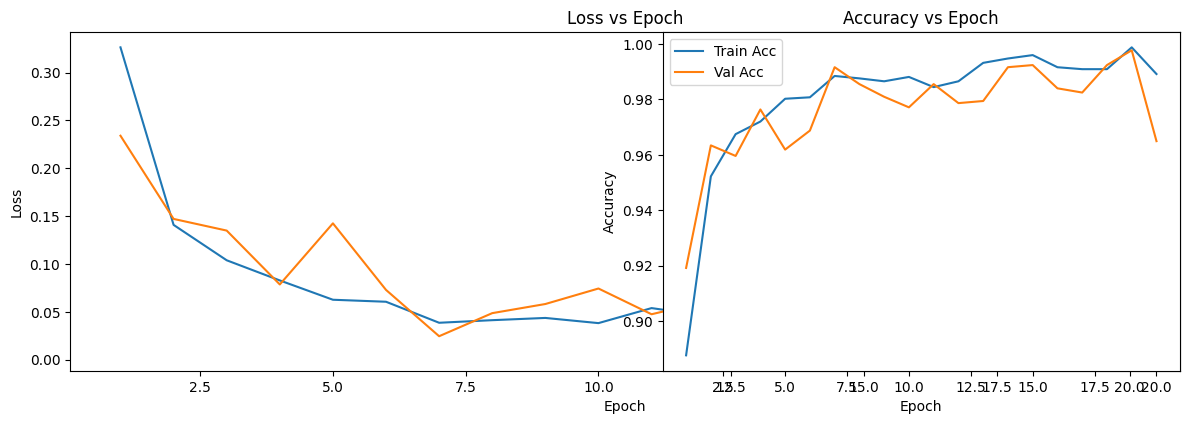

In [21]:
# Plot loss and accuracy
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))
# Loss\	plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.title('Loss vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
# Acc
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.title('Accuracy vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

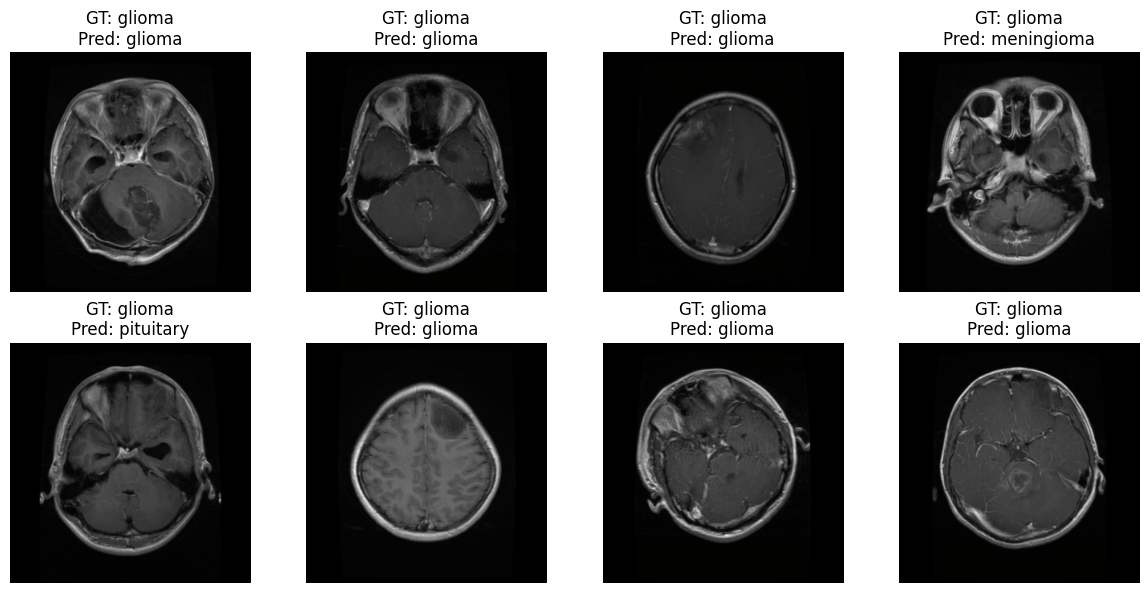

In [22]:
# Un-normalize helper
inv_norm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
def imshow(img, title=None):
    img = inv_norm(img).permute(1,2,0).clamp(0,1).numpy()
    plt.imshow(img); plt.axis('off');
    if title: plt.title(title)

model.eval()
inputs, labels = next(iter(dataloaders['val']))
inputs, labels = inputs.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(inputs)
    preds = outputs.argmax(dim=1)

inputs, labels, preds = inputs.cpu(), labels.cpu(), preds.cpu()
plt.figure(figsize=(12,6))
for i in range(min(8, inputs.size(0))):
    ax = plt.subplot(2,4,i+1)
    imshow(inputs[i], title=f"GT: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
plt.tight_layout(); plt.show()

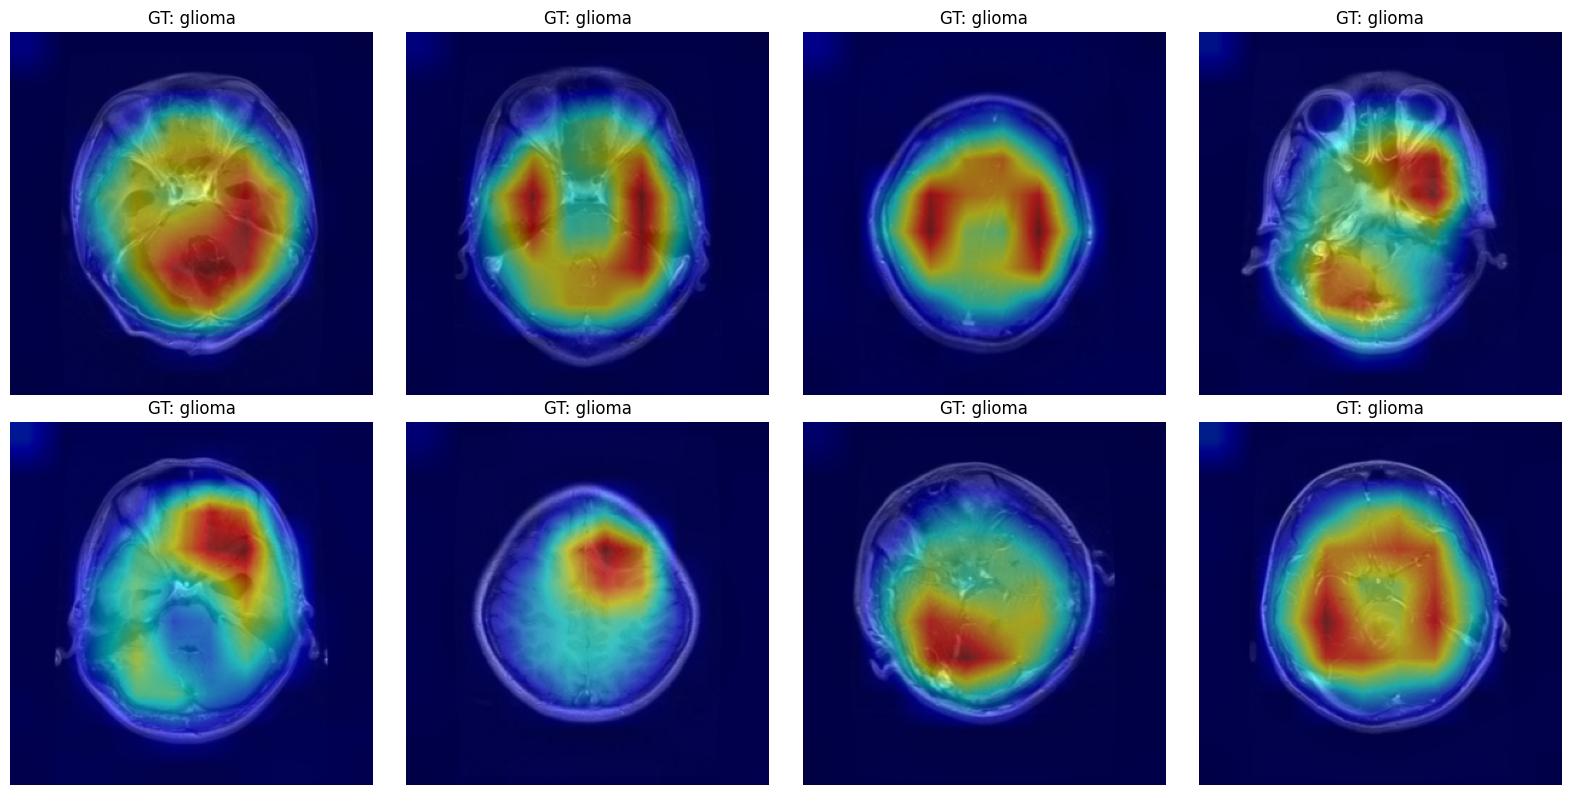

In [77]:
target_layer = model.features[-1]  # last conv layer in VGG16
cam = GradCAM(model=model, target_layers=[target_layer])
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
grayscale_cams = cam(input_tensor=inputs)

plt.figure(figsize=(16,8))
for i in range(min(8, inputs.size(0))):
    img_np = inv_norm(inputs[i]).cpu().permute(1,2,0).clamp(0,1).numpy()
    heatmap = grayscale_cams[i]
    cam_img = show_cam_on_image(img_np, heatmap, use_rgb=True)
    ax = plt.subplot(2,4,i+1)
    plt.imshow(cam_img); plt.title(f"GT: {class_names[labels[i]]}"); plt.axis('off')
plt.tight_layout(); plt.show()

In [59]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 1. Instantiate the exact architecture used in training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vgg16(pretrained=False)          # note the `_bn`
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(class_names))
model.to(device)

# 2. Load weights with strict=False so mismatches don’t blow up
state = torch.load('best_vgg16.pth', map_location=device)
model.load_state_dict(state, strict=False)
model.eval()

# 3. Prediction function
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.485, .456, .406],
                             std=[.229, .224, .225])
    ])
}

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    tensor = data_transforms['val'](img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
    return class_names[pred.item()], conf.item()

# Usage
img_path = "/home/fast/Downloads/Te-no_0010.jpg"
pred_class, confidence = predict_image(img_path)
print(f"Prediction: {pred_class} ({confidence*100:.2f}%)")

Prediction: notumor (100.00%)


In [25]:
# Load pretrained VGG19
model = models.vgg19(pretrained=True)
# Replace the classifier (fc) for our num_classes
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/fast/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/fast/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|████████████████████████████████████████| 548M/548M [00:18<00:00, 31.8MB/s]


In [26]:
### ▶️ Cell 5: Training and Validation Loop
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss':   [], 'val_acc':   []
}
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 30)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc  = running_corrects / len(image_datasets[phase])

        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_vgg19.pth')

print(f"Training complete. Best val Acc: {best_acc:.4f}")

Epoch 1/20
------------------------------
train Loss: 0.3624 Acc: 0.8645
val Loss: 0.1721 Acc: 0.9428
Epoch 2/20
------------------------------
train Loss: 0.2044 Acc: 0.9321
val Loss: 0.1366 Acc: 0.9489
Epoch 3/20
------------------------------
train Loss: 0.1295 Acc: 0.9571
val Loss: 0.0980 Acc: 0.9672
Epoch 4/20
------------------------------
train Loss: 0.0842 Acc: 0.9736
val Loss: 0.0766 Acc: 0.9794
Epoch 5/20
------------------------------
train Loss: 0.0659 Acc: 0.9788
val Loss: 0.0801 Acc: 0.9809
Epoch 6/20
------------------------------
train Loss: 0.0648 Acc: 0.9804
val Loss: 0.1373 Acc: 0.9489
Epoch 7/20
------------------------------
train Loss: 0.0618 Acc: 0.9802
val Loss: 0.1043 Acc: 0.9756
Epoch 8/20
------------------------------
train Loss: 0.0670 Acc: 0.9820
val Loss: 0.0564 Acc: 0.9847
Epoch 9/20
------------------------------
train Loss: 0.0471 Acc: 0.9841
val Loss: 0.2035 Acc: 0.9519
Epoch 10/20
------------------------------
train Loss: 0.0517 Acc: 0.9865
val Loss

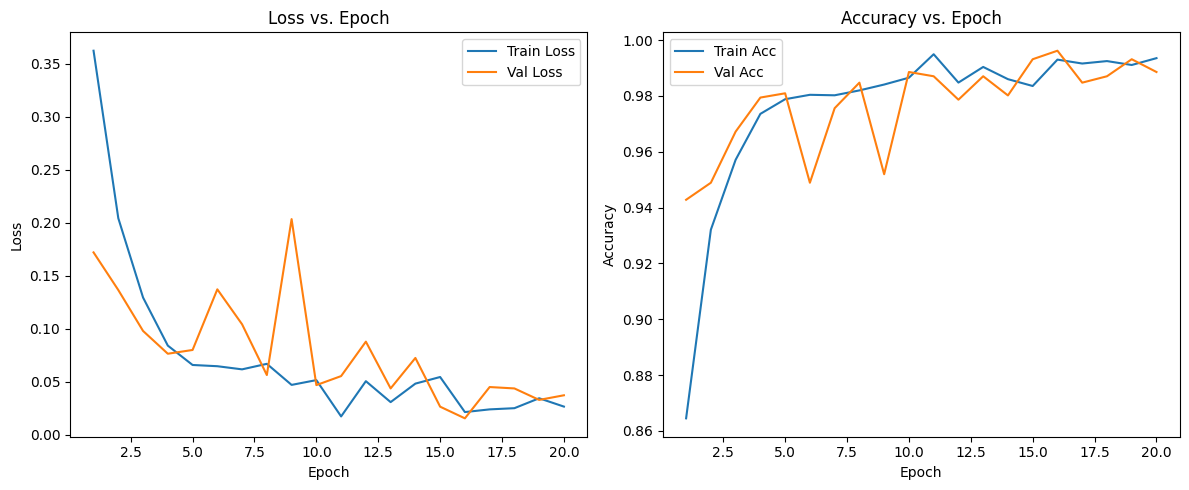

In [27]:
# Plot loss and accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

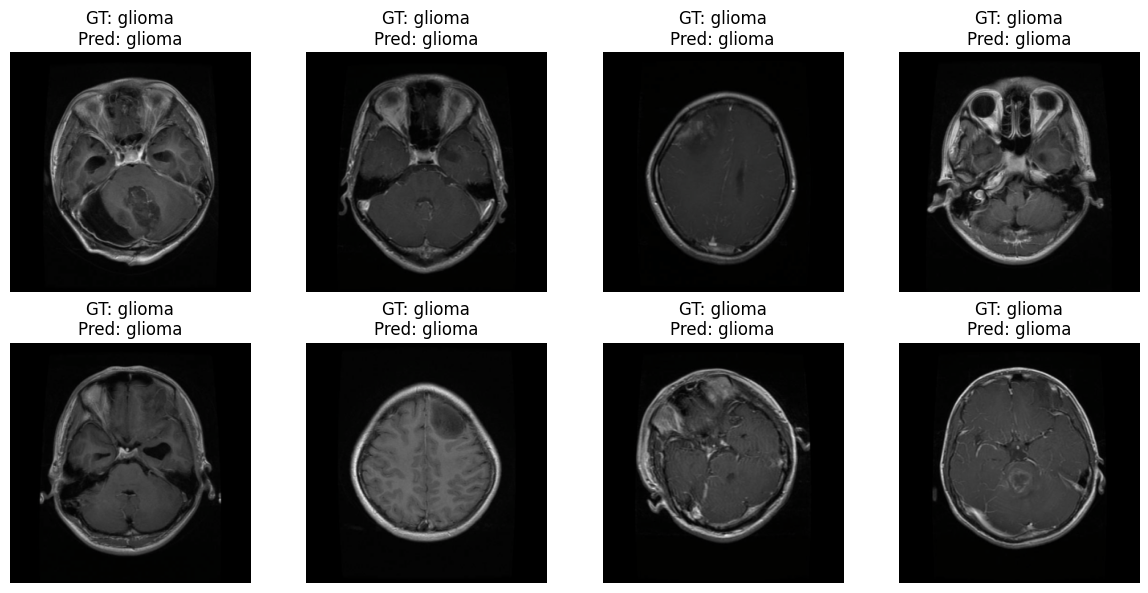

In [28]:
# Un-normalization helper
inv_norm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def imshow(img, title=None):
    img = inv_norm(img).permute(1, 2, 0).clamp(0, 1).numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

model.eval()
inputs, labels = next(iter(dataloaders['val']))
inputs, labels = inputs.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(inputs)
    preds = outputs.argmax(dim=1)

inputs, labels, preds = inputs.cpu(), labels.cpu(), preds.cpu()

plt.figure(figsize=(12, 6))
for i in range(min(8, inputs.size(0))):
    ax = plt.subplot(2, 4, i+1)
    imshow(
        inputs[i],
        title=f"GT: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}"
    )
plt.tight_layout()
plt.show()

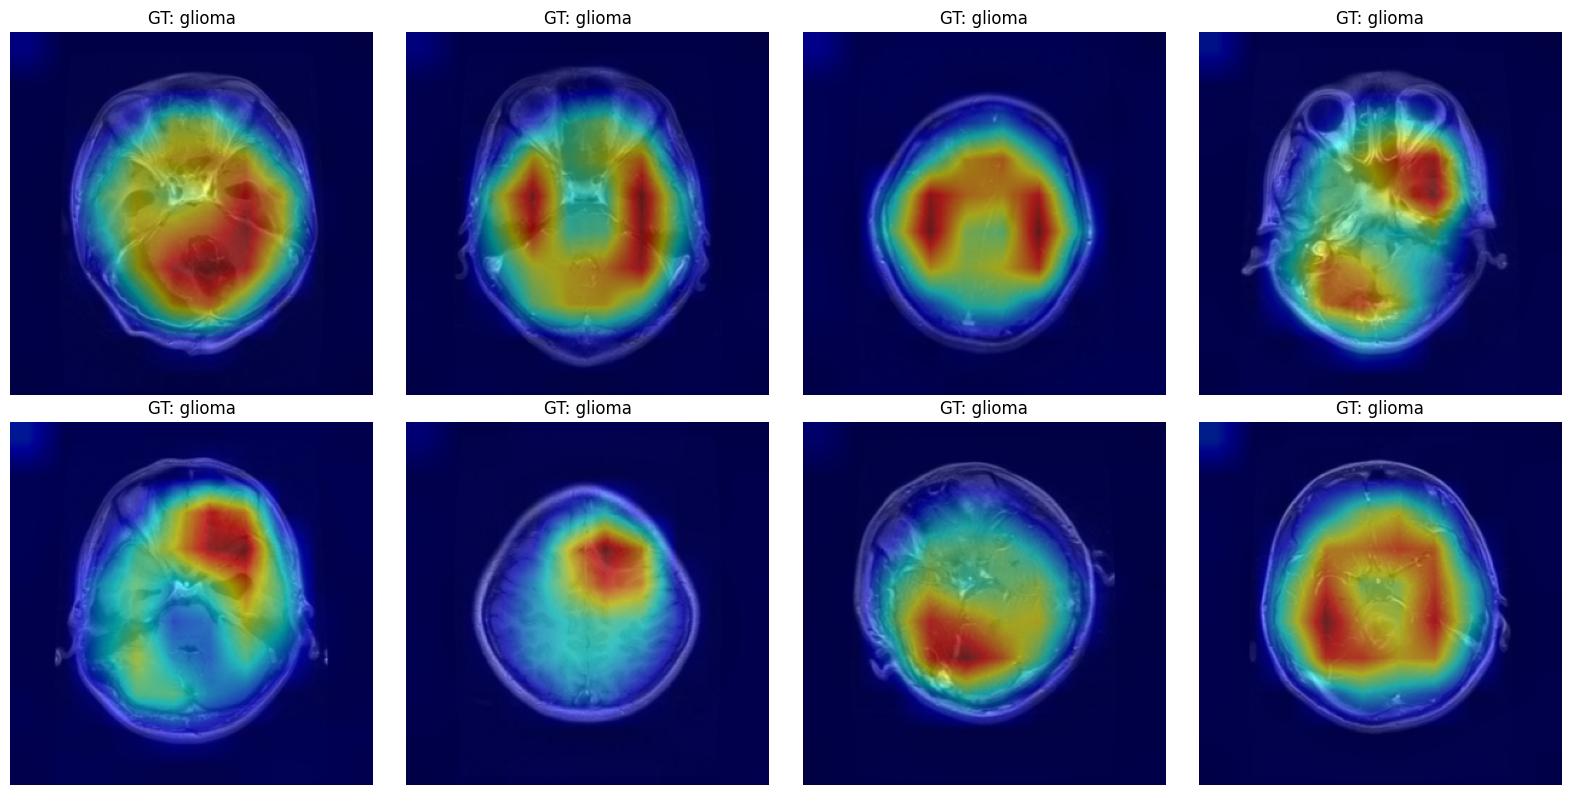

In [78]:
target_layer = model.features[-1]  # last conv layer in VGG19
cam = GradCAM(model=model, target_layers=[target_layer])
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
grayscale_cams = cam(input_tensor=inputs)

plt.figure(figsize=(16, 8))
for i in range(min(8, inputs.size(0))):
    img_np = inv_norm(inputs[i]).cpu().permute(1, 2, 0).clamp(0, 1).numpy()
    heatmap = grayscale_cams[i]
    cam_img = show_cam_on_image(img_np, heatmap, use_rgb=True)

    ax = plt.subplot(2, 4, i+1)
    plt.imshow(cam_img)
    plt.title(f"GT: {class_names[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [85]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# 1. Instantiate the exact architecture used in training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vgg19(pretrained=False)          # note the `_bn`
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(class_names))
model.to(device)

# 2. Load weights with strict=False so mismatches don’t blow up
state = torch.load('best_vgg19.pth', map_location=device)
model.load_state_dict(state, strict=False)
model.eval()

# 3. Prediction function
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.485, .456, .406],
                             std=[.229, .224, .225])
    ])
}

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    tensor = data_transforms['val'](img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
    return class_names[pred.item()], conf.item()

# Usage
img_path = "/home/fast/Downloads/Te-no_0010.jpg"
pred_class, confidence = predict_image(img_path)
print(f"Prediction: {pred_class} ({confidence*100:.2f}%)")

Prediction: notumor (100.00%)


In [18]:
pip install vit-pytorch

Note: you may need to restart the kernel to use updated packages.


In [41]:
# Data transformations

batch_size = 32
num_epochs = 30
learning_rate = 1e-4
image_size = 320  # Must be divisible by patch_size
patch_size = 16   # Ensure image_size % patch_size == 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val'])
}

# Dataloaders
dataloaders = {
    phase: DataLoader(image_datasets[phase], batch_size=batch_size,
                      shuffle=(phase == 'train'), num_workers=4)
    for phase in ['train', 'val']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [42]:
# Initialize ViT model
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=1024,
    dropout=0.1,
    emb_dropout=0.1
)

model.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=768, out_features=512, bias=True)
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
best_model_wts = model.state_dict()
best_acc = 0.0

for epoch in range(num_epochs):
    print('-' * 10)
    print(f'Epoch {epoch+1}/{num_epochs}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

# Load best model weights
model.load_state_dict(best_model_wts)

# Save the best model weights
torch.save(model.state_dict(), 'best_vit.pth')
print("Best model saved as 'best_vit.pth'")

----------
Epoch 1/30
train Loss: 1.0805 Acc: 0.5205
val Loss: 0.9214 Acc: 0.6735
----------
Epoch 2/30
train Loss: 0.7244 Acc: 0.6987
val Loss: 0.7013 Acc: 0.7330
----------
Epoch 3/30
train Loss: 0.5564 Acc: 0.7778
val Loss: 0.5622 Acc: 0.7719
----------
Epoch 4/30
train Loss: 0.4775 Acc: 0.8106
val Loss: 0.7266 Acc: 0.7300
----------
Epoch 5/30
train Loss: 0.4512 Acc: 0.8246
val Loss: 0.5095 Acc: 0.7971
----------
Epoch 6/30
train Loss: 0.4066 Acc: 0.8454
val Loss: 0.4996 Acc: 0.8139
----------
Epoch 7/30
train Loss: 0.3885 Acc: 0.8526
val Loss: 0.4874 Acc: 0.8070
----------
Epoch 8/30
train Loss: 0.3727 Acc: 0.8566
val Loss: 0.4490 Acc: 0.8238
----------
Epoch 9/30
train Loss: 0.3345 Acc: 0.8736
val Loss: 0.3849 Acc: 0.8474
----------
Epoch 10/30
train Loss: 0.3196 Acc: 0.8771
val Loss: 0.5750 Acc: 0.7887
----------
Epoch 11/30
train Loss: 0.3286 Acc: 0.8771
val Loss: 0.4091 Acc: 0.8391
----------
Epoch 12/30
train Loss: 0.3047 Acc: 0.8843
val Loss: 0.4648 Acc: 0.8162
----------
Ep

In [56]:
pip install vit-pytorch grad-cam

Note: you may need to restart the kernel to use updated packages.


In [58]:
# 📦 Cell 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from PIL import Image
from vit_pytorch import ViT

# 📁 Cell 2: Paths and Hyperparameters
train_dir    = "/home/fast/Downloads/binary_dataset/Training"
val_dir      = "/home/fast/Downloads/binary_dataset/Testing"
batch_size   = 32
num_epochs   = 20
learning_rate= 1e-4
weight_decay = 1e-4
image_size   = 320   # divisible by patch_size
patch_size   = 16
patience     = 5     # early-stopping patience

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔄 Cell 3: Data Transforms and Loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomResizedCrop(image_size, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ])
}

image_datasets = {
    phase: datasets.ImageFolder(
        root=(train_dir if phase=='train' else val_dir),
        transform=data_transforms[phase]
    )
    for phase in ['train','val']
}

dataloaders = {
    phase: DataLoader(
        image_datasets[phase],
        batch_size=batch_size,
        shuffle=(phase=='train'),
        num_workers=4,
        pin_memory=True
    )
    for phase in ['train','val']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

# 🧠 Cell 4: Define ViT Model
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=1024,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

# TensorBoard writer
writer = SummaryWriter()

# Initialize history arrays for plotting
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

# ▶️ Cell 5: Training Loop with Early Stopping & Saving
best_model_wts = model.state_dict().copy()
best_loss = float('inf')
no_improve_epochs = 0

for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    for phase in ['train','val']:
        model.train() if phase=='train' else model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)

                if phase=='train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds==labels).sum().item()

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc  = running_corrects / len(image_datasets[phase])

        print(f" {phase:<5} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")
        writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
        writer.add_scalar(f"Acc/{phase}",  epoch_acc,  epoch)

        # record history for plotting
        if phase=='train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)
            scheduler.step(epoch_loss)
            # early stopping logic
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict().copy()
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print("Early stopping triggered")
        break

# Load best weights and save
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'best_vit.pth')
print("\nBest model saved as 'best_vit.pth'")
writer.close()


Epoch 1/20
 train Loss: 1.1385  Acc: 0.4793
 val   Loss: 1.1606  Acc: 0.5065

Epoch 2/20
 train Loss: 0.8134  Acc: 0.6507
 val   Loss: 0.7401  Acc: 0.7140

Epoch 3/20
 train Loss: 0.6661  Acc: 0.7293
 val   Loss: 0.6571  Acc: 0.7521

Epoch 4/20
 train Loss: 0.6041  Acc: 0.7670
 val   Loss: 0.7880  Acc: 0.7117

Epoch 5/20
 train Loss: 0.5705  Acc: 0.7743
 val   Loss: 0.6185  Acc: 0.7567

Epoch 6/20
 train Loss: 0.5278  Acc: 0.7952
 val   Loss: 0.6102  Acc: 0.7513

Epoch 7/20
 train Loss: 0.4925  Acc: 0.8036
 val   Loss: 0.5242  Acc: 0.7834

Epoch 8/20
 train Loss: 0.5061  Acc: 0.8015
 val   Loss: 0.5904  Acc: 0.7574

Epoch 9/20
 train Loss: 0.4621  Acc: 0.8216
 val   Loss: 0.5265  Acc: 0.7826

Epoch 10/20
 train Loss: 0.4540  Acc: 0.8218
 val   Loss: 0.5232  Acc: 0.7826

Epoch 11/20
 train Loss: 0.4255  Acc: 0.8326
 val   Loss: 0.5554  Acc: 0.7941

Epoch 12/20
 train Loss: 0.4357  Acc: 0.8286
 val   Loss: 0.5802  Acc: 0.7605

Epoch 13/20
 train Loss: 0.4182  Acc: 0.8353
 val   Loss: 0.

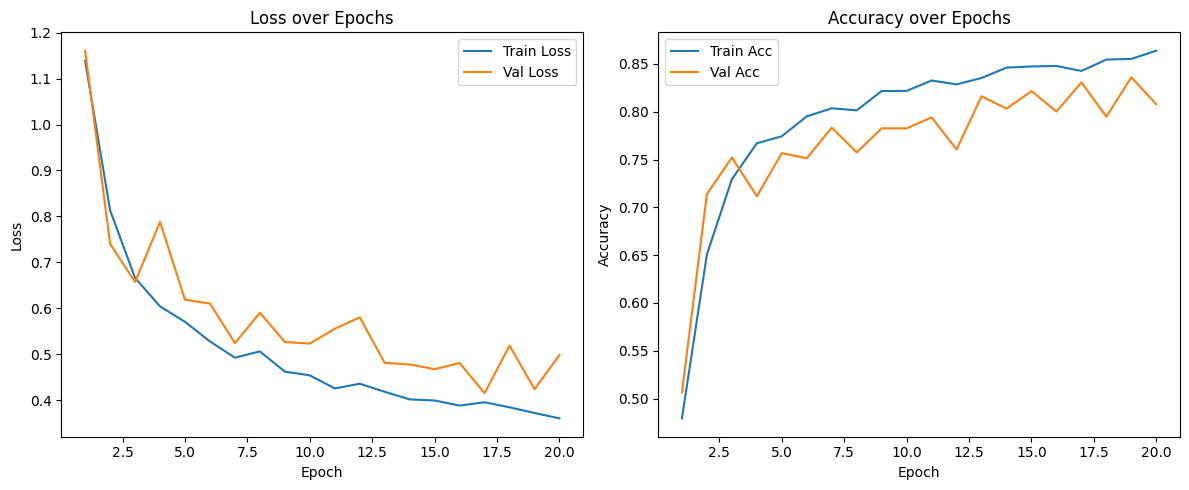

In [59]:
# 📈 Cell 6: Plot Training & Validation Curves
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs,   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [102]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models.vision_transformer import vit_b_16  # assuming ViT-B/16 was used
from PIL import Image

# Define your class names
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']  # change this list as per your training

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Instantiate the same architecture used in training
model = vit_b_16(pretrained=False)  # or vit_b_32, vit_l_16, etc.
model.heads.head = nn.Linear(model.heads.head.in_features, len(class_names))
model.to(device)

# 2. Load trained weights
state = torch.load('best_vit1.pth', map_location=device)
model.load_state_dict(state, strict=False)
model.eval()

# 3. Prediction function with appropriate transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # or the size used during training (ViT usually takes 224x224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    tensor = data_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
    return class_names[pred.item()], conf.item()

# Usage
img_path = "/home/fast/Downloads/Te-no_0010.jpg"
pred_class, confidence = predict_image(img_path)
print(f"Prediction: {pred_class} ({confidence*100:.2f}%)")

Prediction: pituitary (55.44%)


In [12]:
import torch
torch.cuda.empty_cache()

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b3, vgg16, vgg19

# Enable CUDA error debugging (forces errors to appear on failing lines)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Paths and device
dataset_dir = '/home/fast/Downloads/binary_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

NUM_CLASSES = 4  # glioma, meningioma, notumor, pituitary

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset loaders
train_ds = ImageFolder(root=os.path.join(dataset_dir, "Training"), transform=transform)
val_ds   = ImageFolder(root=os.path.join(dataset_dir, "Testing"), transform=transform)

print("Train classes:", train_ds.class_to_idx)
print("Val   classes:", val_ds.class_to_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

# Validate label range
all_labels = torch.cat([lbl for _, lbl in train_loader])
assert 0 <= all_labels.min().item() < NUM_CLASSES and all_labels.max().item() < NUM_CLASSES, (
    "Found labels outside valid range [0..NUM_CLASSES-1]!"
)

def load_base_model(constructor, checkpoint_path, num_classes, device):
    model = constructor(pretrained=False)

    if constructor.__name__.startswith('vgg'):
        in_feats = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_feats, num_classes)
    else:
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)

    state = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(state)

    for p in model.parameters():
        p.requires_grad = False
    model.eval()

    # MOVE TO GPU
    model.to(device)
    return model

# Load models
base_models = {
    'efficientnetb3': load_base_model(efficientnet_b3, 'best_efficientnetb3.pth', NUM_CLASSES, device),
    'vgg16': load_base_model(vgg16, 'best_vgg16.pth', NUM_CLASSES, device),
    'vgg19': load_base_model(vgg19, 'best_vgg19.pth', NUM_CLASSES, device),
}

class StackingEnsemble(nn.Module):
    def __init__(self, bases, hidden=32, num_classes=None):
        super().__init__()
        self.bases = nn.ModuleList(bases.values())

        if num_classes is None:
            num_classes = self.bases[0].classifier[-1].out_features
        in_feats = len(self.bases) * num_classes
        self.meta = nn.Sequential(
            nn.Linear(in_feats, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes),
        )

    def forward(self, x):
        logits = [m(x) for m in self.bases]
        stacked = torch.cat(logits, dim=1)
        return self.meta(stacked)

# Instantiate ensemble & move to GPU
ensemble = StackingEnsemble(base_models, hidden=64, num_classes=NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(ensemble.meta.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Debugging: Print model parameter shapes before training
print("Model parameter shapes:")
for name, param in ensemble.named_parameters():
    print(f"{name}: {param.shape}")

# Training loop
for epoch in range(1, 11):
    ensemble.train()
    running_loss = total = correct = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # Debug: Ensure labels are within range before processing
        assert labels.min().item() >= 0 and labels.max().item() < NUM_CLASSES, (
            f"Batch labels out of range {labels.min().item()}..{labels.max().item()}!"
        )

        optimizer.zero_grad()
        out = ensemble(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"[Epoch {epoch}] Train: loss={running_loss/total:.4f}, acc={correct/total:.4f}")

    # Validation
    ensemble.eval()
    v_corr = v_tot = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = ensemble(imgs).argmax(dim=1)
            v_corr += (preds == labels).sum().item()
            v_tot  += labels.size(0)
    print(f"[Epoch {epoch}] Val acc: {v_corr/v_tot:.4f}\n")

    # Free unused GPU memory
    torch.cuda.empty_cache()

# Save trained meta-learner
torch.save(ensemble.state_dict(), 'stacking_meta.pth')
print("Meta-learner saved as stacking_meta.pth")

Using device: cuda
Train classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Val   classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


/home/fast/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fast/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model parameter shapes:
bases.0.features.0.0.weight: torch.Size([40, 3, 3, 3])
bases.0.features.0.1.weight: torch.Size([40])
bases.0.features.0.1.bias: torch.Size([40])
bases.0.features.1.0.block.0.0.weight: torch.Size([40, 1, 3, 3])
bases.0.features.1.0.block.0.1.weight: torch.Size([40])
bases.0.features.1.0.block.0.1.bias: torch.Size([40])
bases.0.features.1.0.block.1.fc1.weight: torch.Size([10, 40, 1, 1])
bases.0.features.1.0.block.1.fc1.bias: torch.Size([10])
bases.0.features.1.0.block.1.fc2.weight: torch.Size([40, 10, 1, 1])
bases.0.features.1.0.block.1.fc2.bias: torch.Size([40])
bases.0.features.1.0.block.2.0.weight: torch.Size([24, 40, 1, 1])
bases.0.features.1.0.block.2.1.weight: torch.Size([24])
bases.0.features.1.0.block.2.1.bias: torch.Size([24])
bases.0.features.1.1.block.0.0.weight: torch.Size([24, 1, 3, 3])
bases.0.features.1.1.block.0.1.weight: torch.Size([24])
bases.0.features.1.1.block.0.1.bias: torch.Size([24])
bases.0.features.1.1.block.1.fc1.weight: torch.Size([6, 2

In [1]:
import os
import torch
import torch.nn as nn
import torchvision                           # needed for accessing torchvision.models namespace
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b3, vgg16, vgg19
from PIL import Image

# 1) Configuration
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

NUM_CLASSES = 4
MODEL_DIR = '/home/fast/Downloads/binary_dataset'
META_CHECKPOINT = 'stacking_meta.pth'
BASE_CHECKPOINTS = {
    efficientnet_b3: 'best_efficientnetb3.pth',
    vgg16:           'best_vgg16.pth',
    vgg19:           'best_vgg19.pth',
}

# 2) Helper to load each base model
def load_base(constructor, ckpt_path):
    model = constructor(pretrained=False)
    # replace final classification layer
    if constructor.__name__.startswith('vgg'):
        in_feats = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_feats, NUM_CLASSES)
    else:  # EfficientNet
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, NUM_CLASSES)

    # load weights & move to device
    state = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(state)
    model.eval().to(device)
    return model

# build dict of loaded base models
base_models = {
    constructor.__name__: load_base(constructor, ckpt_path)
    for constructor, ckpt_path in BASE_CHECKPOINTS.items()
}


# 3) Define stacking ensemble
class StackingEnsemble(nn.Module):
    def __init__(self, bases, hidden=64):
        super().__init__()
        self.bases = nn.ModuleList(bases.values())
        in_feats = len(bases) * NUM_CLASSES
        self.meta = nn.Sequential(
            nn.Linear(in_feats, hidden),
            nn.ReLU(),
            nn.Linear(hidden, NUM_CLASSES),
        )
    def forward(self, x):
        logits = [m(x) for m in self.bases]
        return self.meta(torch.cat(logits, dim=1))

# Instantiate and load both base + meta weights at once:
ensemble = StackingEnsemble(base_models).to(device)
ensemble.load_state_dict(torch.load(META_CHECKPOINT, map_location=device))
ensemble.eval()
print("Ensemble loaded and ready for inference.")


# 4) Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 5A) Batch inference on test folder
test_ds = ImageFolder(root=os.path.join(MODEL_DIR, 'Testing'), transform=transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
class_names = test_ds.classes

correct = total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = ensemble(imgs).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f} ({correct}/{total})")

# 5B) Single-image inference helper
def predict_image(image_path):
    """Run inference on a single image file."""
    img = Image.open(image_path).convert('RGB')
    inp = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = ensemble(inp)
        probs = torch.softmax(out, dim=1)[0]
        idx = probs.argmax().item()
    return class_names[idx], probs[idx].item()

# Example usage:
label, conf = predict_image('/home/fast/Downloads/Te-no_0010.jpg')
print(f"Predicted: {label} (confidence: {conf:.3f})")

Using device: cuda


/home/fast/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fast/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Ensemble loaded and ready for inference.
Test Accuracy: 0.9939 (1303/1311)
Predicted: notumor (confidence: 1.000)
